# Tutorial: Creating Your First QA Pipeline with Retrieval-Augmentation On Custom Documents Using Haystack


## Installing Haystack

Install Haystack 2.0 and other required packages with `pip`:

In [1]:
%%bash

pip install haystack-ai
pip install "datasets>=2.6.1"
pip install "sentence-transformers>=2.2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.9 MB/s eta 0:00:00


## Fetching and Indexing Documents

You'll start creating your question answering system by downloading the data and indexing the data with its embeddings to a DocumenStore.

In this tutorial, you will take a simple approach to writing documents and their embeddings into the DocumenStore. For a full indexing pipeline with preprocessing, cleaning and splitting, check out our tutorial on [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline).


### Initializing the DocumentStore

Initialize a DocumentStore to index your documents. A DocumentStore stores the Documents that the question answering system uses to find answers to your questions. In this tutorial, you'll be using the `InMemoryDocumentStore`.

In [2]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

> `InMemoryDocumentStore` is the simplest DocumentStore to get started with. It requires no external dependencies and it's a good option for smaller projects and debugging. But it doesn't scale up so well to larger Document collections, so it's not a good choice for production systems. To learn more about the different types of external databases that Haystack supports, see [DocumentStore Integrations](https://haystack.deepset.ai/integrations?type=Document+Store).

The DocumentStore is now ready. Now it's time to fill it with some Documents.

### Fetch the Data

 Here, we query the poetryDB API to obtain poems by Shakespeare and store as a json file

In [7]:
from datasets import load_dataset
from haystack import Document


In [8]:
import requests
import json

In [11]:

url="https://poetrydb.org/author/"
author_name="William Shakespeare"

data=requests.get(url+author_name)
data=data.json()
# print(data)

with open("data.json", "w") as outfile:
    json.dump(data, outfile)


with open("data.json") as f:
    data = json.load(f)

documents = []
for doc in data:
    lines=''
    for line in doc["lines"]:
        lines=line+''

    documents.append(
        Document(
            content="Title: " + doc["title"] + " " + lines,
        )
    )



## Building the RAG Pipeline

The next step is to build a [Pipeline](https://docs.haystack.deepset.ai/v2.0/docs/pipelines) to generate answers for the user query following the RAG approach. To create the pipeline, you first need to initialize each component, add them to your pipeline, and connect them.

### Initialize the Retriever

Initialize a InMemoryBM25Retriever and make it use the InMemoryDocumentStore you initialized earlier in this tutorial. This Retriever will get the relevant documents to the query.

In [56]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store=document_store)

### Define a Template Prompt

Create a custom prompt for a generative question answering task using the RAG approach. The prompt should take in two parameters: `documents`, which are retrieved from a document store, and a `question` from the user. Use the Jinja2 looping syntax to combine the content of the retrieved documents in the prompt.

Next, initialize a [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder) instance with your prompt template. The PromptBuilder, when given the necessary values, will automatically fill in the variable values and generate a complete prompt. This approach allows for a more tailored and effective question-answering experience.

In [57]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

### Initialize a Generator


Generators are the components that interact with large language models (LLMs). Now, set `OPENAI_API_KEY` environment variable and initialize a [OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/OpenAIGenerator) that can communicate with OpenAI GPT models. As you initialize, provide a model name:

In [59]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")
generator = OpenAIGenerator(model="gpt-3.5-turbo")

> You can replace `OpenAIGenerator` in your pipeline with another `Generator`. Check out the full list of generators [here](https://docs.haystack.deepset.ai/v2.0/docs/generators).

### Build the Pipeline

To build a pipeline, add all components to your pipeline and connect them. Create connections from `text_embedder`'s "embedding" output to "query_embedding" input of `retriever`, from `retriever` to `prompt_builder` and from `prompt_builder` to `llm`. Explicitly connect the output of `retriever` with "documents" input of the `prompt_builder` to make the connection obvious as `prompt_builder` has two inputs ("documents" and "question").

For more information on pipelines and creating connections, refer to [Creating Pipelines](https://docs.haystack.deepset.ai/v2.0/docs/creating-pipelines) documentation.

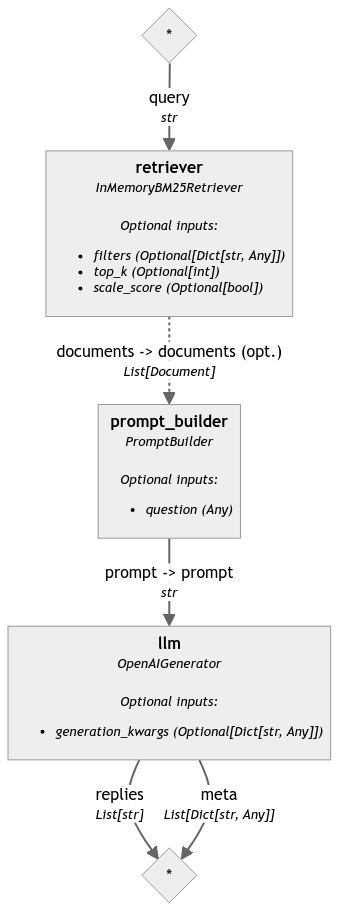

In [60]:
from haystack import Pipeline

basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")


That's it! Your RAG pipeline is ready to generate answers to questions!

## Asking a Question

When asking a question, use the `run()` method of the pipeline. Make sure to provide the question to both the `text_embedder` and the `prompt_builder`. This ensures that the `{{question}}` variable in the template prompt gets replaced with your specific question.

In [61]:
question = "Give a short summary about Sonnet 12"
results = basic_rag_pipeline.run(
    {
        "retriever": {"query": question},
        "prompt_builder": {"question": question}
    }
)

Ranking by BM25...: 0 docs [00:00, ? docs/s]

Here are some other example questions to test:

In [72]:
print(results["llm"]['replies'][0])

Sonnet 12, written by William Shakespeare, is part of the series of 154 sonnets that focus on the themes of time and mortality. In this sonnet, the speaker reflects on the destructive power of time and how it will inevitably take away beauty and youth. The speaker uses imagery of seasons changing, flowers wilting, and the passing of time to convey the idea that everything in life is temporary and will eventually fade away. Despite the melancholy tone, the sonnet also suggests that the power of poetry can preserve beauty and youth beyond the passage of time.
